In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None, name=None):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])
    if name:
        plt.savefig(f'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Brute force results/{name}.png', 
                    bbox_inches='tight')

In [4]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/Keras_SVHN/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
vmax = 0.1

# SVHN

## Quantizing Weights

In [10]:
name = 'svhn_keras'
model_path = 'svhn_keras/svhn_keras.h5'

from test_models.svhn_keras import data
_, test_data = data.get_data()

keras_svhn = model_data.Model(name, test_data, path=save_path+model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Forward quantization

In [ ]:
scores_ = brute_force_analysis_weights(keras_svhn, layer_names, bw_range, f_range)
np.save(output_path + 'scores_1_w', arr=scores_)

In [12]:
parameters = {'conv2d_1': [6, 6]}

scores_1_1 = brute_force_analysis_weights(keras_svhn, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [7, 7]}
scores_1_2 = brute_force_analysis_weights(keras_svhn, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [8, 8]}
scores_1_3 = brute_force_analysis_weights(keras_svhn, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [9, 9]}
scores_1_4 = brute_force_analysis_weights(keras_svhn, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_1_1', scores_1_1)
np.save(output_path + 'scores_1_2', scores_1_2)
np.save(output_path + 'scores_1_3', scores_1_3)
np.save(output_path + 'scores_1_4', scores_1_4)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [ ]:
parameters = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6]
}
scores_2 = brute_force_analysis_weights(keras_svhn, layer_names[2:], bw_range, f_range,
                                fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_2', arr=scores_2)

In [ ]:
parameters = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5]
}
scores_3 = brute_force_analysis_weights(keras_svhn, layer_names[3:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_3', arr=scores_3)

In [ ]:
parameters = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5]
}
scores_4 = brute_force_analysis_weights(keras_svhn, layer_names[4:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_4', arr=scores_4)

In [5]:
# Use this cell to load scores for plotting if scores are already saved
scores_ = np.load(output_path + 'scores_1_w.npy')
# scores_1_1 = np.load(output_path + 'scores_1_1.npy')
# scores_1_2 = np.load(output_path + 'scores_1_2.npy')
# scores_1_3 = np.load(output_path + 'scores_1_3.npy')
# scores_1_4 = np.load(output_path + 'scores_1_4.npy')
# scores_2 = np.load(output_path + 'scores_2.npy')
# scores_3 = np.load(output_path + 'scores_3.npy')
# scores_4 = np.load(output_path + 'scores_4.npy')

In [ ]:
vmax=0.1

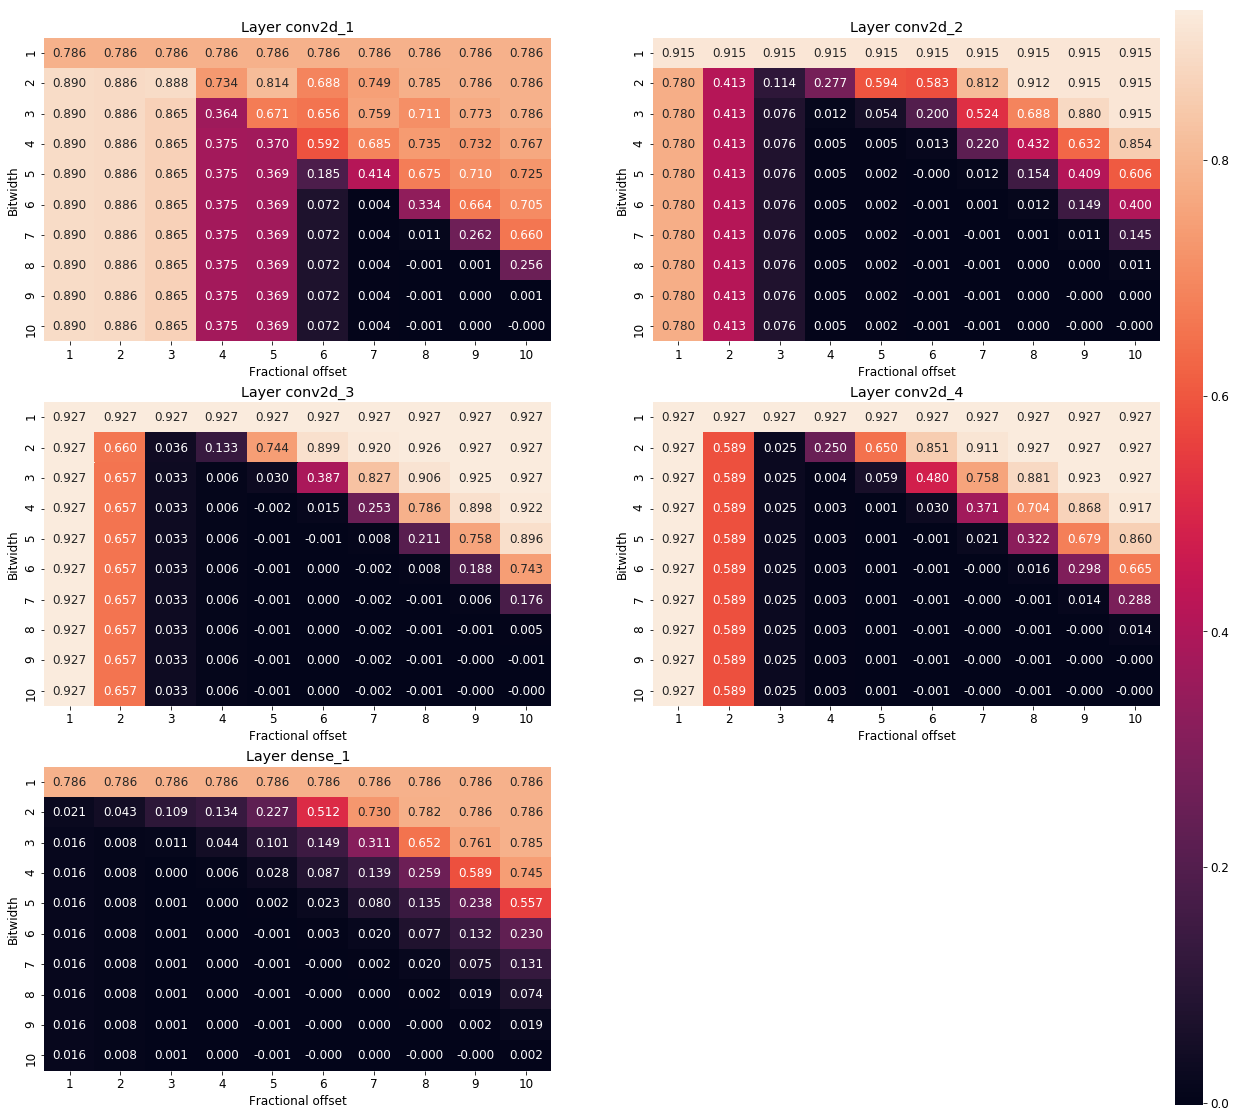

In [6]:
# independent quantization without biases
plot_results(scores_, layer_names, 3, 2, (20, 19), 0.8, bw_range, f_range, vmax=None, name='keras_svhn_w')

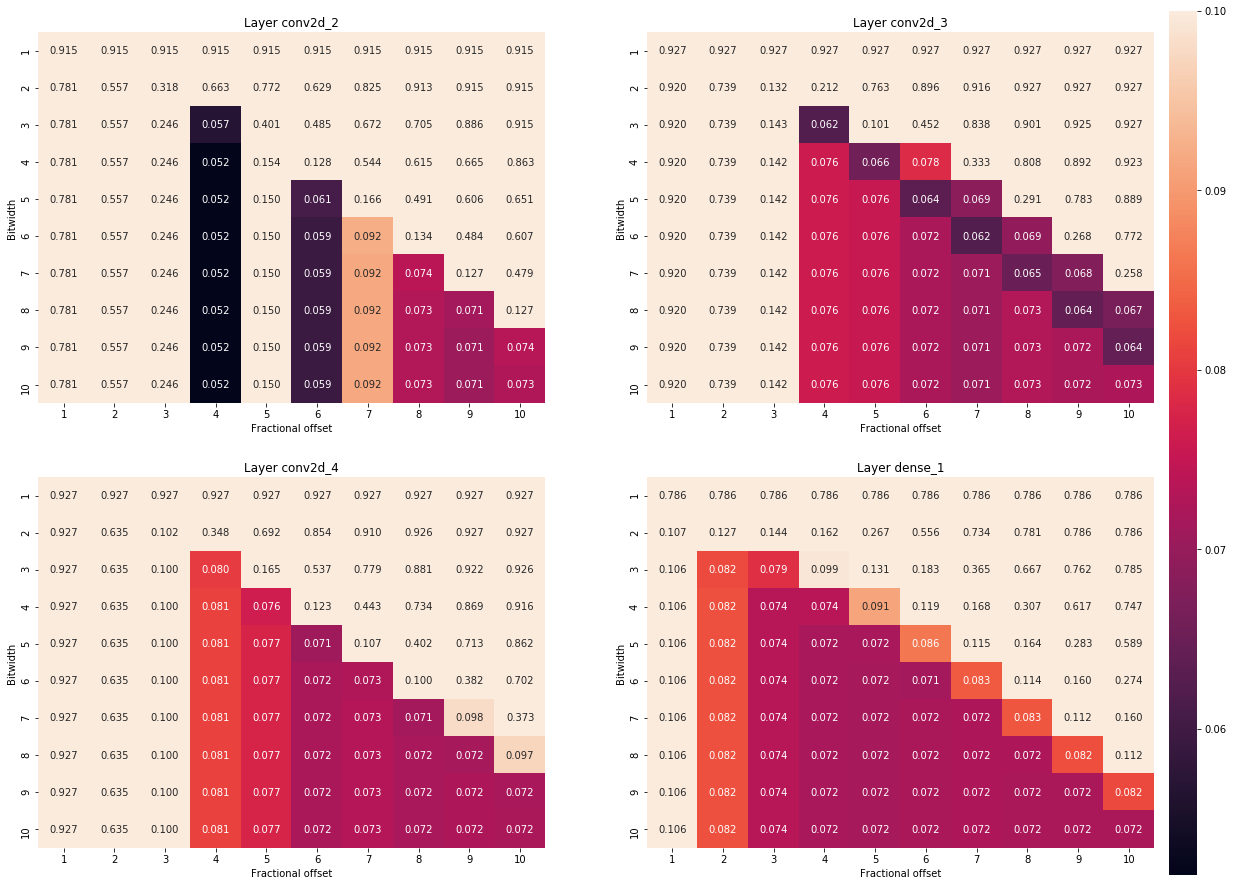

In [10]:
plot_results(scores_1_1, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

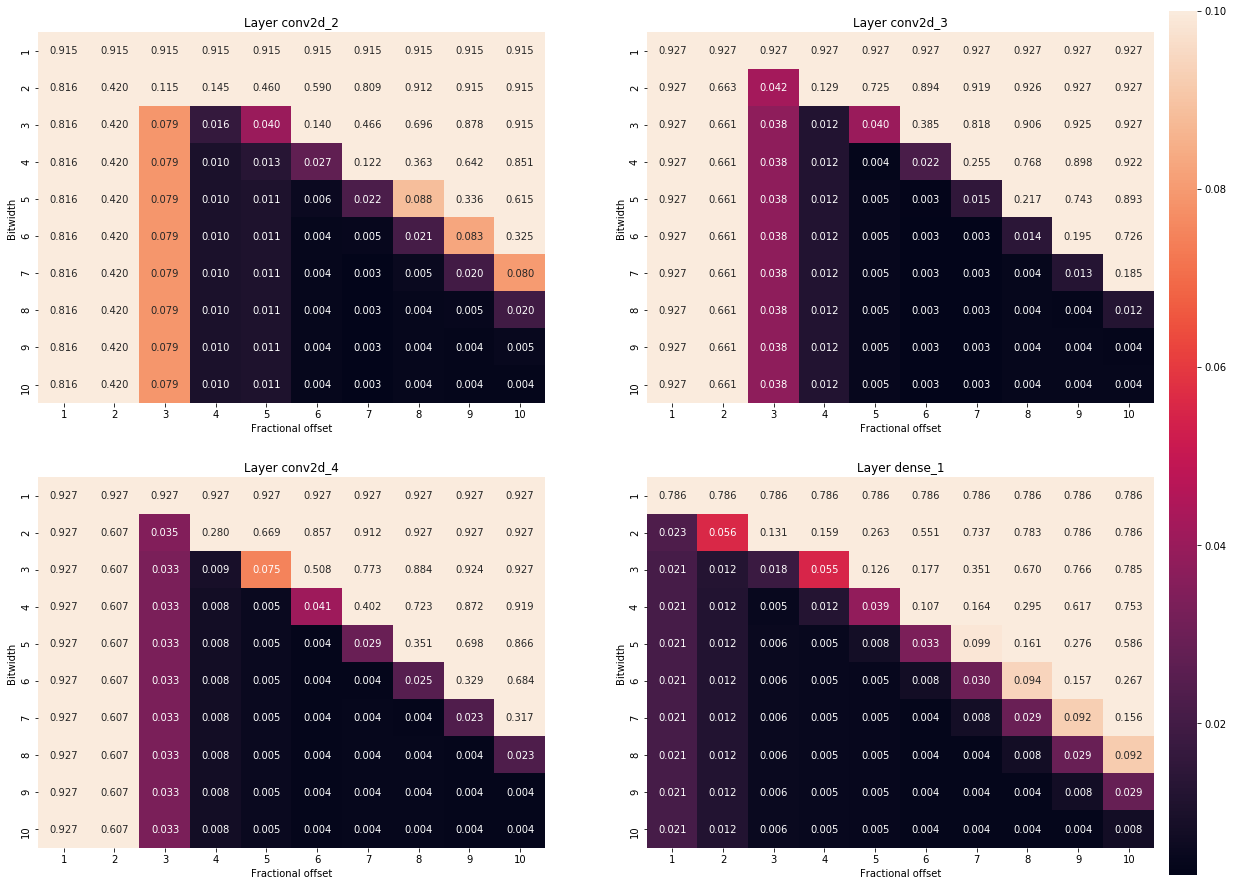

In [11]:
plot_results(scores_1_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

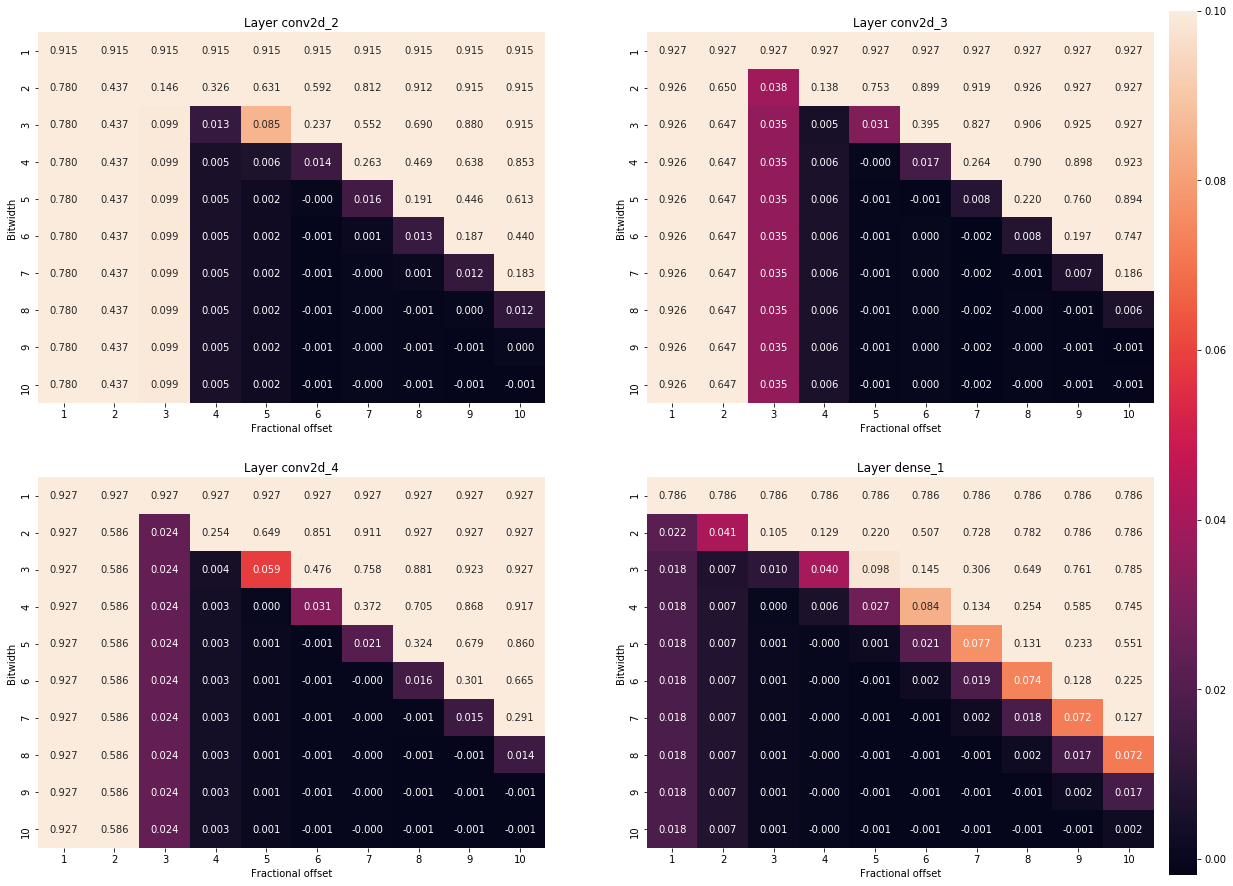

In [12]:
plot_results(scores_1_3, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

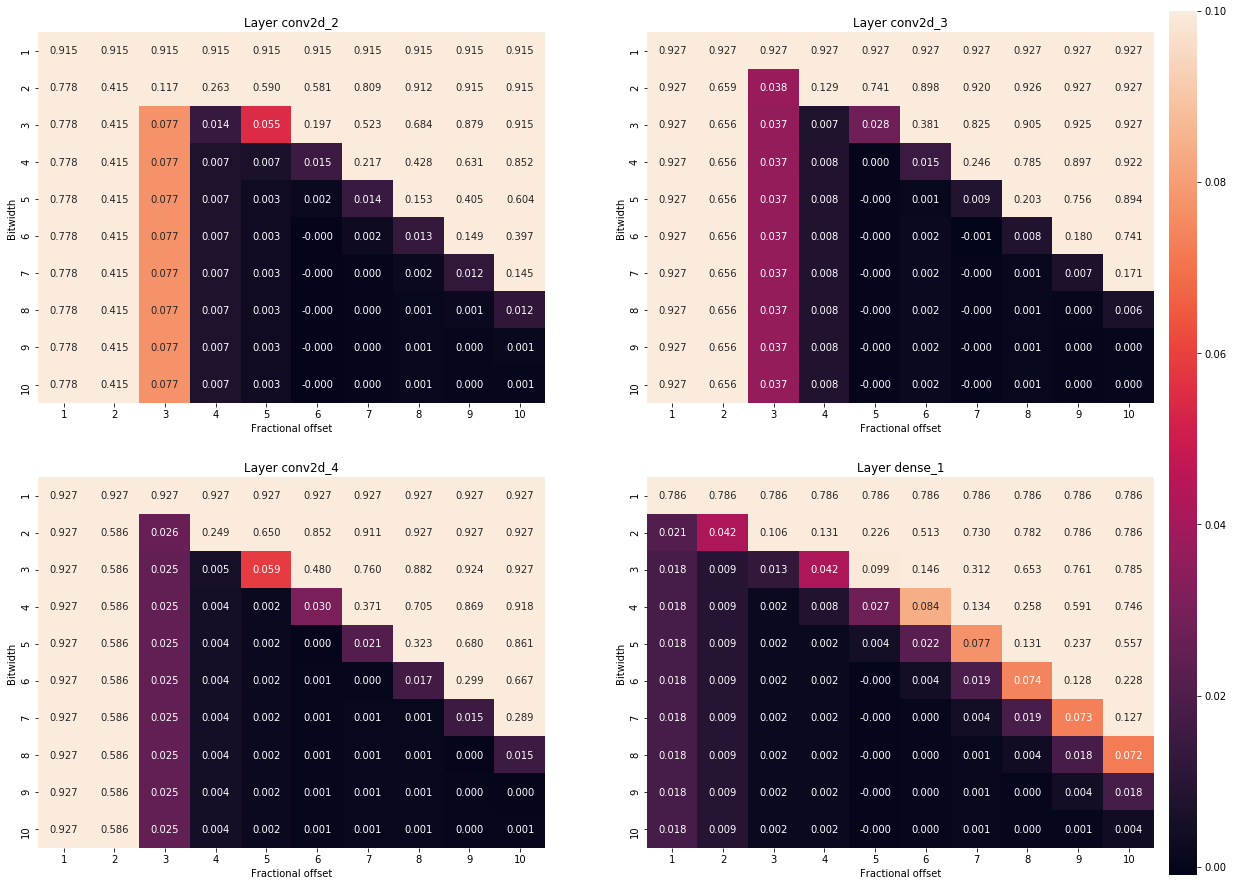

In [13]:
plot_results(scores_1_4, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

The following plot for conv2d_3 is important because we see that the value of the inference accuracy alternates a little between 0.002 and 0.001 for alternate values of F. This may cause problems when searching for the optimum value. 

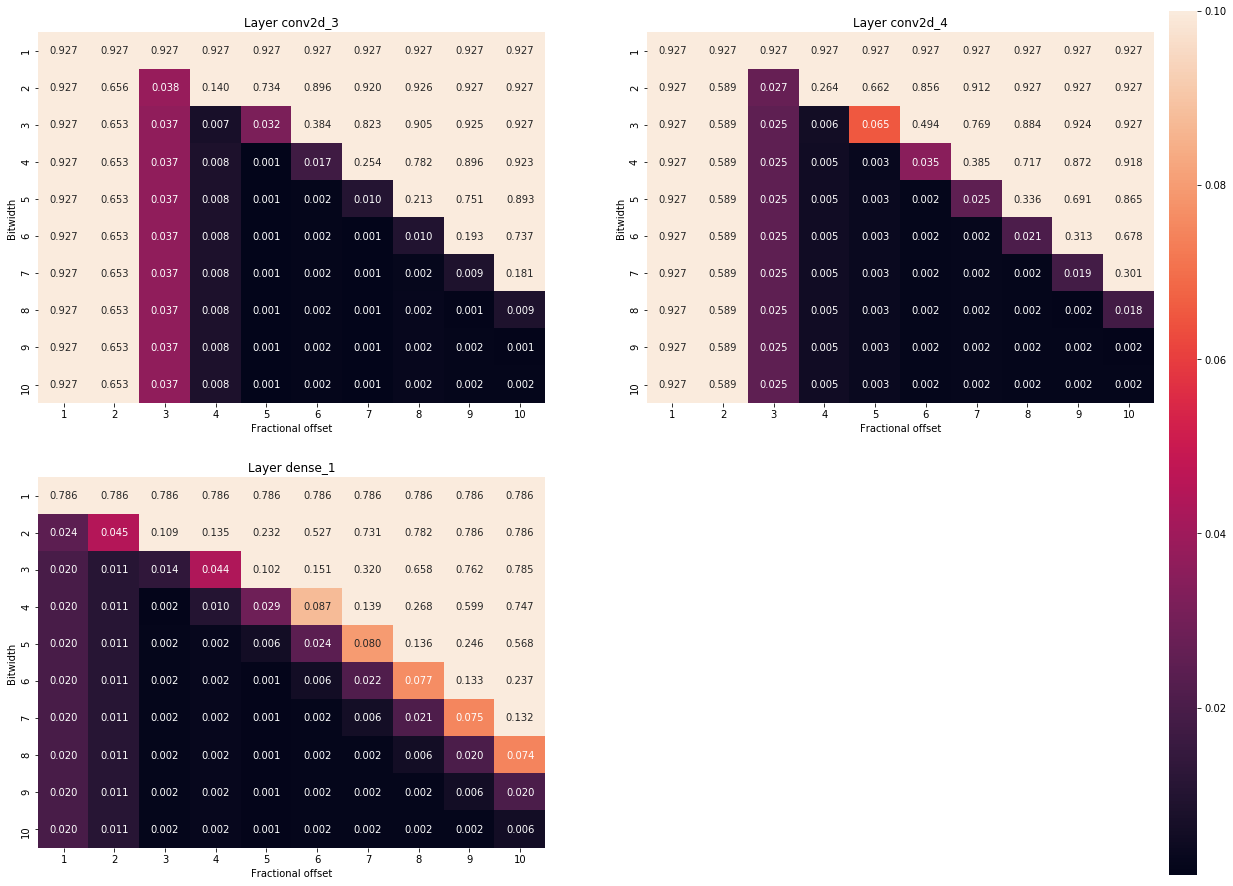

In [14]:
plot_results(scores_2, layer_names[2:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

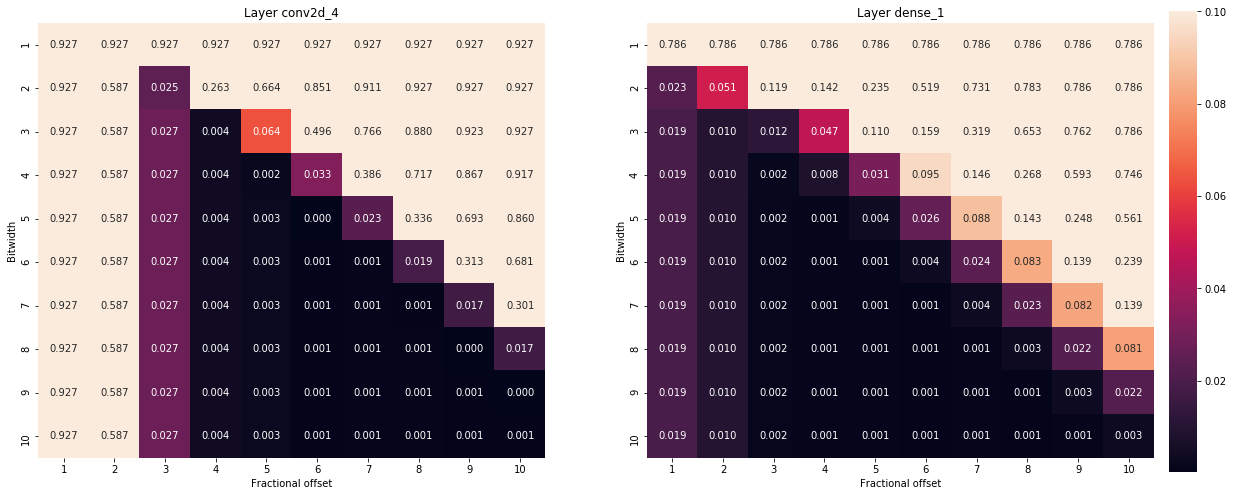

In [15]:
plot_results(scores_3, layer_names[3:], 1, 2, (20, 8), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


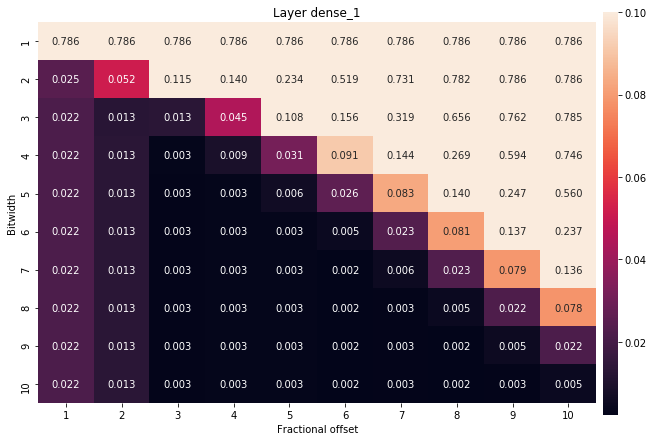

In [16]:
plot_results(scores_4, layer_names[4:], 1, 1, (10, 7), 0.8, bw_range, f_range, vmax=vmax)

#### Visualize weight distribution of final result

In [ ]:
keras_svhn.load_model_from_path()
keras_svhn.evaluate_accuracy()[1]

In [ ]:
# original set of weights
w = keras_svhn.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [ ]:
parameters = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
for k in parameters.keys():
    keras_svhn.model = fxp_quantize.quantize_weights(keras_svhn.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

In [ ]:
# Quantized set of weights
w = keras_svhn.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [ ]:
keras_svhn.evaluate_accuracy()[1]

#### Compare activation distributions before and after quantization

In [ ]:
keras_svhn.load_model_from_path()
act_maps_before_quant = keras_svhn.get_activation_maps(keras_svhn.x_test[0].reshape(1, 32, 32, 3), 'conv2d_4')
parameters = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
for k in parameters.keys():
    keras_svhn.model = fxp_quantize.quantize_weights(keras_svhn.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

act_maps_after_quant = keras_svhn.get_activation_maps(keras_svhn.x_test[0].reshape(1, 32, 32, 3), 'conv2d_4')

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.hist(act_maps_before_quant.flat, bins=100, label='before');
plt.hist(act_maps_after_quant.flat, bins=100, label='after');
plt.legend()

In [ ]:
d = act_maps_after_quant - act_maps_before_quant
plt.hist(d.flat, bins=30);
plt.title('Difference in activation distributions before and after quantization');

##### Observations

- Similar to the other datasets, we observe that applying conservative quantization for weights results in predictable behaviour in that we can choose the same parameters for quantizing the layers as we did when quantizing them independently. This is especially evident when we fix the quantization of layer 1 too harshly, which results in quite a lot of unpredictable behaviour as far as the plot is concerned. Reference to plots diff_1_1 - diff_1_4. Additionally, applying harsher quantization seems to have an effect on the value of F we can use. It seems to be better to use a larger value of F for the same bit-width, whenever possible. 
- In the experiment for scores_2, where we fixed the quantization of layers 1 and 2, and looked at quantization of layer 3, we can see that for alternate values of the fractional offset F, we see alternating values of the inference accuracy. In the process of designing an algorithm to find an optimum point, similar to gradient descent, this might lead to issues as the algorithm would get stuck in the same place. In such a situation, we must either relax the conditions of our optimum until we converge to a point that is worse, or think of another approach. 
- Similar to CIFAR10, we see that layer 1 and 2 do not allow for too much quantization, as can be seen from the resulting weight distributions. 
- Layer 1 also is very sensitive to quantization, which was also seen in for the case of CIFAR10. MNIST, allowed for harsher quantization. I suspect that this is because of the fact that MNIST is an easier dataset.
- We therefore must quantize conservatively in order to have predictable behaviour for the successive layers, and in order to minimize the drop in inference accuracy.
- The distribution of the weights after quantization will vary given that we apply quantization differently to each layer. 

#### Check differences

Observe the differences in the heatmaps against their independent quantization heatmaps

In [ ]:
diff_1_1 = np.abs(scores_[:, :, 1] - scores_1_1[:, :, 0])
diff_1_2 = np.abs(scores_[:, :, 1] - scores_1_2[:, :, 0])
diff_1_3 = np.abs(scores_[:, :, 1] - scores_1_3[:, :, 0])
diff_1_4 = np.abs(scores_[:, :, 1] - scores_1_4[:, :, 0])
diff_2 = np.abs(scores_[:, :, 2] - scores_2[:, :, 0])
diff_3 = np.abs(scores_[:, :, 3] - scores_3[:, :, 0])
diff_4 = np.abs(scores_[:, :, 4] - scores_4)

In [ ]:
diff = np.dstack((diff_1_1, diff_1_2, diff_1_3, diff_1_4, diff_2, diff_3, diff_4))
names = ['diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_1_4', 'diff_2', 'diff_3', 'diff_4']
plot_results(diff, names, 4, 2, (20, 25), 0.8, bw_range, f_range, vmax=0.05)

### Reverse Quantization

In [ ]:
parameters = {
    'dense_1': [4, 3]
}
scores_r1_1 = brute_force_analysis_weights(keras_svhn, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_1', arr=scores_r1_1)

parameters = {
    'dense_1': [3, 2]
}
scores_r1_2 = brute_force_analysis_weights(keras_svhn, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_2', arr=scores_r1_2)

In [ ]:
parameters = {
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
scores_r2 = brute_force_analysis_weights(keras_svhn, layer_names[:-2], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r2', arr=scores_r2)

In [ ]:
parameters = {
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
scores_r3 = brute_force_analysis_weights(keras_svhn, layer_names[:-3], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r3', arr=scores_r3)

In [ ]:
parameters = {
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
scores_r4 = brute_force_analysis_weights(keras_svhn, layer_names[:-4], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r4', arr=scores_r4)

In [ ]:
plot_results(scores_r1_1, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

In [ ]:
plot_results(scores_r1_2, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

In [ ]:
plot_results(scores_r2, layer_names[:-2], 1, 3, (20, 6), 0.8, bw_range, f_range, vmax=vmax)

In [ ]:
plot_results(scores_r3, layer_names[:-3], 1, 2, (15, 6), 0.8, bw_range, f_range, vmax=vmax)

In [ ]:
plot_results(scores_r4, layer_names[:-4], 1, 1, (10, 6), 0.8, bw_range, f_range, vmax=vmax)

##### Observations

- After applying reverse quantization, we see that the choice for quantization parameters for layer 1 are still the same as those we would choose independently.
- Clearly, layer 1 is remains to be more sensitive to quantization than the later layers, possibly because it has the least number of parameters to be quantized.

In [ ]:
keras_svhn.load_model_from_path()
print(f'Original floating point model inference accuracy: {keras_svhn.evaluate_accuracy()[1]}')

w_quant_params = {
    'conv2d_1': [9, 9],
    'conv2d_2': [5, 6],
    'conv2d_3': [4, 5],
    'conv2d_4': [4, 5],
    'dense_1': [4, 3]
}
keras_svhn = fix_weights_quantization(keras_svhn, w_quant_params)

print(f'Fixed-point quantized weights model inference accuracy: {keras_svhn.evaluate_accuracy()[1]}')

## Quantizing Biases

In [ ]:
def fix_biases_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_biases(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model


def brute_force_analysis_biases(model, layer_names, bw_range, f_range, fix_w_quant=False, w_parameters=None,
                                fix_b_quant=False, b_parameters=None, eval_metric='acc_drop'):
    
    if (fix_w_quant and w_parameters is None) or (fix_b_quant and b_parameters is None):
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_w_quant:
                    model = fix_weights_quantization(model, w_parameters)
                    
                if fix_b_quant:
                    model = fix_biases_quantization(model, b_parameters)

                model.model = fxp_quantize.quantize_biases(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [ ]:
scores_b_1 = brute_force_analysis_biases(keras_svhn, layer_names, bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params)

In [ ]:
np.save(output_path + 'scores_b_1', arr=scores_b_1)

In [ ]:
plot_results(scores_b_1, layer_names, 2, 3, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [ ]:
b_quant_params = {
    'conv2d_1': [9, 10],
}
scores_b_2 = brute_force_analysis_biases(keras_svhn, layer_names[1:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)

In [ ]:
plot_results(scores_b_2, layer_names[1:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [ ]:
np.save(output_path + 'scores_b_2', arr=scores_b_2)

In [ ]:
b_quant_params = {
    'conv2d_1': [9, 10],
    'conv2d_2': [2, 4]
}
scores_b_3 = brute_force_analysis_biases(keras_svhn, layer_names[2:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)

In [ ]:
plot_results(scores_b_3, layer_names[2:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [ ]:
np.save(output_path + 'scores_b_3', arr=scores_b_3)

In [ ]:
b_quant_params = {
    'conv2d_1': [9, 10],
    'conv2d_2': [2, 4],
    'conv2d_3': [2, 3]
}
scores_b_4 = brute_force_analysis_biases(keras_svhn, layer_names[3:], bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_4', arr=scores_b_4)

In [ ]:
plot_results(scores_b_4, layer_names[3:], 1, 2, (20, 6), 0.8, bw_range, f_range, vmax=0.01)